In [45]:
import numpy as np
import logging
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

logging.basicConfig(level=logging.INFO, format='%(message)s')
def print_aligned_title(title):
    total_length = 80
    title_length = len(title)
    left_padding_length = (total_length - title_length) // 2
    right_padding_length = total_length - title_length - left_padding_length
    aligned_title = left_padding_length * "=" + " " + title + " " + right_padding_length * "="
    logging.info(aligned_title)

# 数据集
class RecordDataset(Dataset):
    def __init__(self, csv_file, sequence_length):
        self.data = pd.read_csv(csv_file)
        self.data_samples = self.data[
            [
                "throttle_percentage",
                "brake_percentage",
                "speed_mps",
                "steering_percentage",
                "acceleration_current_point",
                "acceleration_next_point",
                "angular_velocity_vrf",
            ]
        ]

        self.sequence_length = sequence_length
        self.throttle_count = 0
        self.brake_count = 0
        big_group = []
        index_tokeep = []

        normalization_list = [[] for _ in range(len(self.data_samples.columns))]
        # TODO:以指针形式选择数据，减少数据的复制移动
        # 清理数据
        for i in range(len(self.data_samples)):
            steering_condition = (
                abs(self.data_samples.at[i, "steering_percentage"]) <= 1
            )
            cmd_condition1 = (
                self.data_samples.at[i, "throttle_percentage"] >= 1
                or self.data_samples.at[i, "brake_percentage"] >= 1
            )
            cmd_condition2 = not (
                self.data_samples.at[i, "throttle_percentage"] > 0
                and self.data_samples.at[i, "brake_percentage"] > 0
            )
            speed_condition = self.data_samples.at[i, "speed_mps"] > 0

            if (
                steering_condition
                and cmd_condition1
                and cmd_condition2
                and speed_condition
            ):
                index_tokeep.append(i)

            else:
                if len(index_tokeep) >= self.sequence_length:
                    # 存储需要归一化的数据
                    for idx in index_tokeep:
                        row_data = self.data_samples.iloc[idx]
                        for col_idx, col_name in enumerate(self.data_samples.columns):
                            normalization_list[col_idx].append(row_data[col_name])

                    small_group_data = [
                        self.data_samples.iloc[idx] for idx in index_tokeep
                    ]
                    small_group_df = pd.DataFrame(small_group_data)
                    big_group.append(small_group_df)
                index_tokeep = []

        # 最后一个数据
        if len(index_tokeep) >= self.sequence_length:
            for idx in index_tokeep:
                row_data = self.data_samples.iloc[idx]
                for col_idx, col_name in enumerate(self.data_samples.columns):
                    normalization_list[col_idx].append(row_data[col_name])
            small_group_data = [self.data_samples.iloc[idx] for idx in index_tokeep]
            small_group_df = pd.DataFrame(small_group_data)
            big_group.append(small_group_df)

        # 归一化
        normalization_list = np.array(normalization_list)
        max_list = np.max(normalization_list, axis=1)
        min_list = np.min(normalization_list, axis=1)
        max_difference = max_list - min_list
        for group in big_group:
            for data_idx, row_data in group.iterrows():
                if row_data["throttle_percentage"] > 0:
                    self.throttle_count += 1
                else:
                    self.brake_count += 1
                group.loc[data_idx] = (row_data - min_list) / (max_list - min_list)

        self.samples = []
        for group in big_group:
            for i in range(len(group)):
                if i + sequence_length <= len(group):
                    self.samples.append(group.iloc[i : i + sequence_length])

        print_aligned_title("Data processing")
        print(f"Total original samples: {len(self.data_samples)}")
        print(f"Total filtered samples: {len(self.samples)}")
        print(f"throttle left:{self.throttle_count}, brake left:{self.brake_count}\n")


    def __len__(self):
        return len(self.samples)

    # 选择用于训练的列
    def __getitem__(self, idx):
        features = torch.tensor(
            self.samples[idx].iloc[:, :3].values, dtype=torch.float32
        )
        target = torch.tensor(
            self.samples[idx].iloc[-1, -3:-2].values, dtype=torch.float32
        )
        return features, target


# 网络
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out


# 训练
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for features, target in train_loader:
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader)}")


# 测试
def test(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            outputs = model(features)
            loss = criterion(outputs, target)
            total_loss += loss.item()
        print(f"Test Loss: {total_loss / len(test_loader)}")


if __name__ == "__main__":

    input_size = 3
    hidden_size = 8
    num_layers = 2
    output_size = 1
    batch_size = 32
    learning_rate = 0.001
    epochs = 100
    sequence_length = 20
    csv_file = "/home/cyn/cs/NeuralNetwork_python/vehicle_model/record.csv"
    save_path = "VehicleModel.pth"
    print_aligned_title("Config")
    print(f"input size:{input_size}, ouput size:{output_size}, hidden size:{hidden_size}, num layers:{num_layers}")
    print(f"batch size:{batch_size}, learning rate:{learning_rate}, epochs:{epochs}, sequence length: {sequence_length}\n")

    # 数据集
    dataset = RecordDataset(csv_file, sequence_length)
    train_size = int(0.8 * len(dataset))  # 训练集占比 80%
    val_size = len(dataset) - train_size  # 验证集占比 20%
    train_set, val_set = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

    # 模型
    model = LSTM(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 训练
    train(model, train_loader, criterion, optimizer, epochs)

    torch.save(model.state_dict(), save_path)
    print("\nModel saved successfully.")


===================================== Config =====================================


input size:3, ouput size:1, hidden size:8, num layers:2
batch size:32, learning rate:0.001, epochs:100, sequence length: 20



================================ Data processing =================================


Total original samples: 307509
Total filtered samples: 51267
throttle left:41507, brake left:16049

Epoch [1/100], Loss: 0.0013555199405909065
Epoch [2/100], Loss: 0.0011879605554780605


KeyboardInterrupt: 

In [41]:
# 测试
test_loader = DataLoader(val_set, batch_size=batch_size)
test(model, test_loader, criterion)

Test Loss: 0.0011146910226761692


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split

csv_file = "/home/cyn/cs/NeuralNetwork_python/vehicle_model/record.csv"
data = pd.read_csv(csv_file)
data_samples = data[
      [
          "throttle_percentage",
          "brake_percentage",
          "steering_percentage",
          "speed_mps",
          "acceleration_current_point",
          "acceleration_next_point",
          "angular_velocity_vrf",
      ]
  ].head(4)
for index,row in data_samples.iterrows():

  print(row)
  list = [1,1,1,1,1,1,1]
  row+=list
for index,row in data_samples.iterrows():
  print(row)



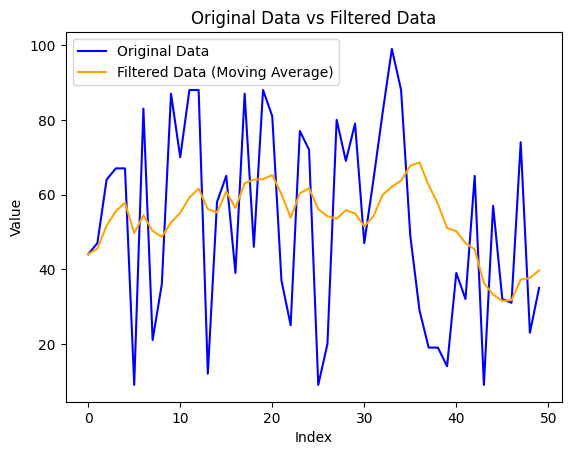

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 创建一个杂乱的示例数据
np.random.seed(0)
data = pd.Series(np.random.randint(0, 100, size=50))

# 定义移动平均滤波函数
def moving_average_filter(data, window_size):
    # 使用较小的窗口大小来填充初始的 NaN 值
    filled_data = data.rolling(window=window_size, min_periods=1).mean()
    return filled_data

# 应用移动平均滤波
window_size = 10
filtered_data = moving_average_filter(data, window_size)

# 绘制原始数据和滤波后的数据的折线图
plt.plot(data, label="Original Data", color="blue")
plt.plot(filtered_data, label="Filtered Data (Moving Average)", color="orange")

# 添加标题和图例
plt.title("Original Data vs Filtered Data")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()

# 显示图形
plt.show()
